UAP

Nama: Nilton Is Marcal
Nim: 202210370311181


preprocessing_dataset.py

In [2]:
import pandas as pd
import numpy as np
import re

DATA_PATH = "scrapped_Spotify_ Putar Musik_ Podcast.csv"
OUT_PATH = "spotify_uap_6000_balanced.csv"
TARGET_PER_CLASS = 2000  # 2000 negatif, 2000 netral, 2000 positif

df = pd.read_csv(DATA_PATH, low_memory=False)

# Ambil kolom penting
df = df[["content", "score"]].copy()
df = df.rename(columns={"content": "text", "score": "rating"})
df["text"] = df["text"].astype(str)
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# Label 3 kelas dari rating
def rating_to_label(r):
    if pd.isna(r):
        return np.nan
    if r >= 4:
        return "positif"
    if r <= 2:
        return "negatif"
    return "netral"

df["label"] = df["rating"].apply(rating_to_label)

# Cleaning teks
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)      # hapus link
    s = re.sub(r"[^a-z0-9\s]", " ", s)          # hapus simbol
    s = re.sub(r"\s+", " ", s).strip()          # rapikan spasi
    return s

df["text_clean"] = df["text"].apply(clean_text)

# Drop kosong & duplikat
df = df.dropna(subset=["text_clean", "label"])
df = df.drop_duplicates(subset=["text_clean"])

print("Distribusi label (sebelum sampling):")
print(df["label"].value_counts())
print("Total bersih:", len(df))

# Balanced sampling 6000
df_bal = (df.groupby("label", group_keys=False)
            .apply(lambda x: x.sample(n=TARGET_PER_CLASS, random_state=42)))
df_bal = df_bal.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nDistribusi label (setelah sampling):")
print(df_bal["label"].value_counts())
print("Total balanced:", len(df_bal))

df_bal[["text_clean", "label"]].to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)


Distribusi label (sebelum sampling):
label
positif    23980
negatif    14617
netral      4073
Name: count, dtype: int64
Total bersih: 42670

Distribusi label (setelah sampling):
label
negatif    2000
netral     2000
positif    2000
Name: count, dtype: int64
Total balanced: 6000
Saved: spotify_uap_6000_balanced.csv


/tmp/ipython-input-117296612.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=TARGET_PER_CLASS, random_state=42)))


exploratory_data_analysis.py

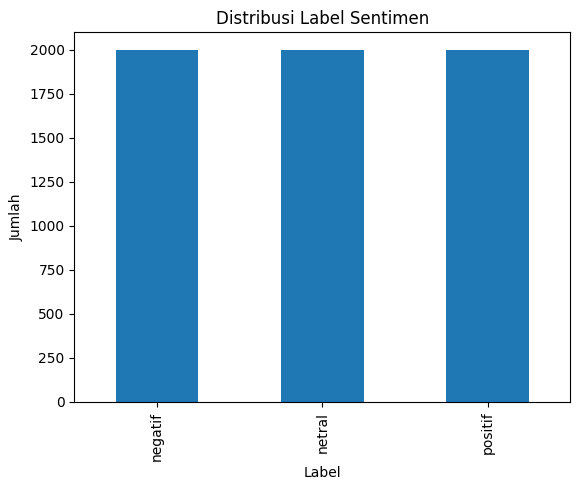

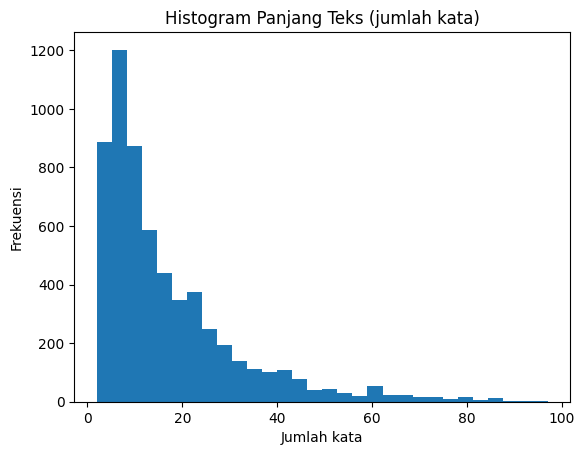

                                          text_clean    label  len
0            jelek suka error padahal udah langganan  negatif    6
1  menurut ku aplikasinya bagus cuman yang kurang...   netral   24
2                    tidak percaya lagi sama spotify  negatif    5
3  kebanyakan iklan dari pada mendengarkan lagu 9...   netral   34
4  sumpahh inii apk enak bettt gak ada iklan lg m...  positif   16


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = "spotify_uap_6000_balanced.csv"
df = pd.read_csv(DATA_PATH)

# Distribusi label
counts = df["label"].value_counts()
plt.figure()
counts.plot(kind="bar")
plt.title("Distribusi Label Sentimen")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

# Panjang teks
df["len"] = df["text_clean"].astype(str).apply(lambda x: len(x.split()))
plt.figure()
plt.hist(df["len"], bins=30)
plt.title("Histogram Panjang Teks (jumlah kata)")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()

print(df.head())


train_base_model_bilstm.py

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4002 - loss: 1.0552 - val_accuracy: 0.5823 - val_loss: 0.8372
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6516 - loss: 0.7716 - val_accuracy: 0.6260 - val_loss: 0.8015
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7566 - loss: 0.6141 - val_accuracy: 0.6552 - val_loss: 0.8350
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8275 - loss: 0.4673 - val_accuracy: 0.6083 - val_loss: 0.9849
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8763 - loss: 0.3601 - val_accuracy: 0.5917 - val_loss: 1.0835


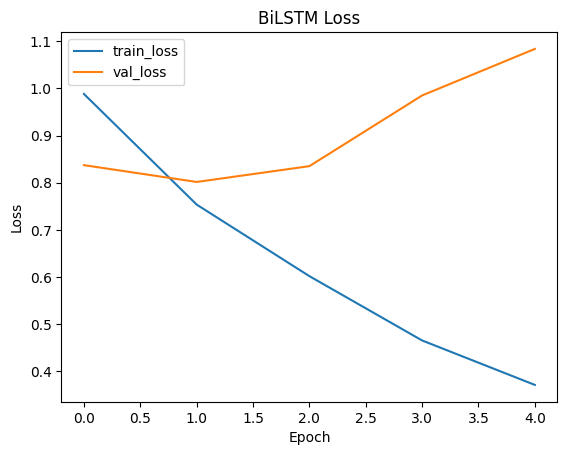

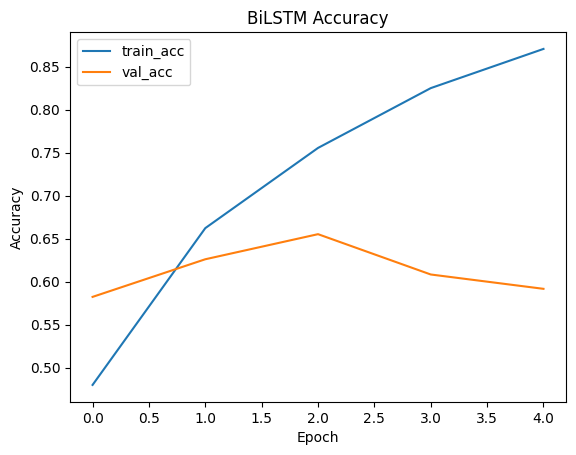

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Classification Report (BiLSTM):
              precision    recall  f1-score   support

     negatif       0.57      0.57      0.57       400
      netral       0.45      0.53      0.49       400
     positif       0.79      0.66      0.72       400

    accuracy                           0.58      1200
   macro avg       0.60      0.58      0.59      1200
weighted avg       0.60      0.58      0.59      1200

Confusion Matrix (BiLSTM):
[[227 154  19]
 [138 211  51]
 [ 36 100 264]]


In [8]:
import json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

DATA_PATH = "spotify_uap_6000_balanced.csv"
MODEL_DIR = "models/base_bilstm.keras" # Added .keras extension

df = pd.read_csv(DATA_PATH)
X = df["text_clean"].astype(str).values
y = df["label"].astype(str).values

# Encode label
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Save label classes (buat streamlit)
import os
os.makedirs("models", exist_ok=True)
with open("models/label_classes.json", "w") as f:
    json.dump(le.classes_.tolist(), f)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Tokenizer Keras
VOCAB_SIZE = 30000
MAXLEN = 100

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(X_train), maxlen=MAXLEN, padding="post"
)
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(X_test), maxlen=MAXLEN, padding="post"
)

# Save tokenizer (buat streamlit)
with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

num_classes = len(le.classes_)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 128, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train_seq, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)

# Save model
model.save(MODEL_DIR)

# Plot loss & accuracy (wajib modul)
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("BiLSTM Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("BiLSTM Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Evaluate
y_pred = np.argmax(model.predict(X_test_seq), axis=1)
print("Classification Report (BiLSTM):")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix (BiLSTM):")
print(confusion_matrix(y_test, y_pred))

train_pretrained_indobert.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.6 MB/s eta 0:00:00
Train size: 4800 Test size: 1200
Classes: ['negatif' 'netral' 'positif']


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4006924203.py:96: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.765900,0.708776,0.674167,0.670017
2,0.600000,0.735918,0.670833,0.672108



=== Classification Report (IndoBERT) ===
              precision    recall  f1-score   support

     negatif       0.64      0.69      0.66       400
      netral       0.56      0.55      0.55       400
     positif       0.83      0.77      0.80       400

    accuracy                           0.67      1200
   macro avg       0.67      0.67      0.67      1200
weighted avg       0.67      0.67      0.67      1200

=== Confusion Matrix (Raw) ===
[[277 109  14]
 [132 219  49]
 [ 26  65 309]]


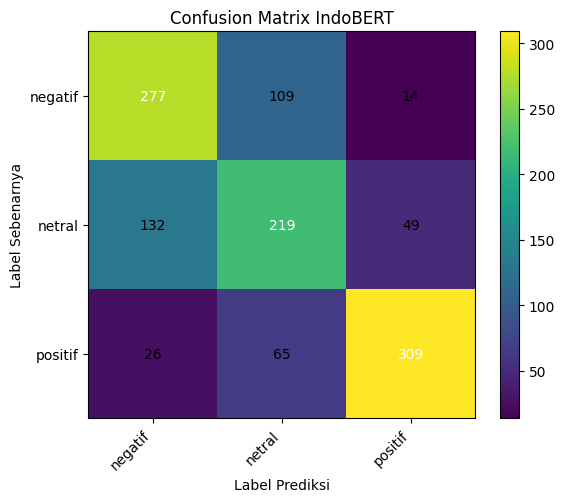

Saved image: cm_indobert.png


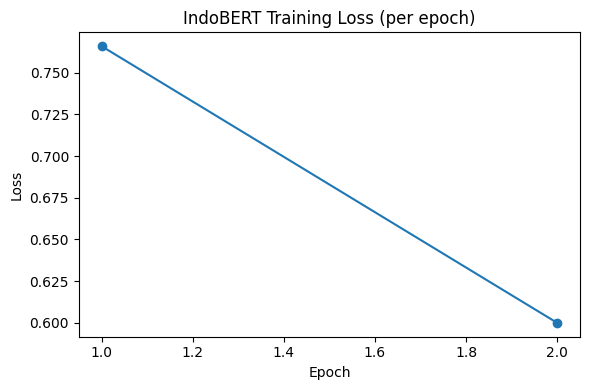

Saved image: loss_indobert.png


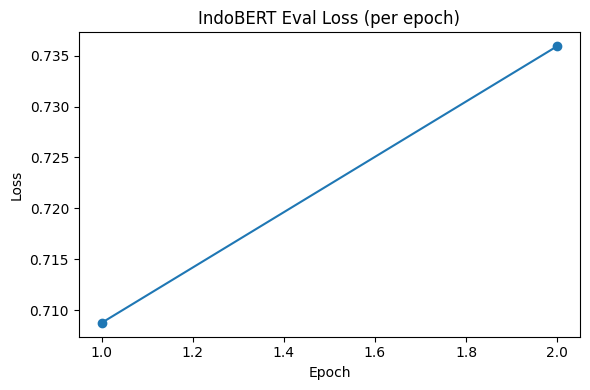

Saved image: eval_loss_indobert.png


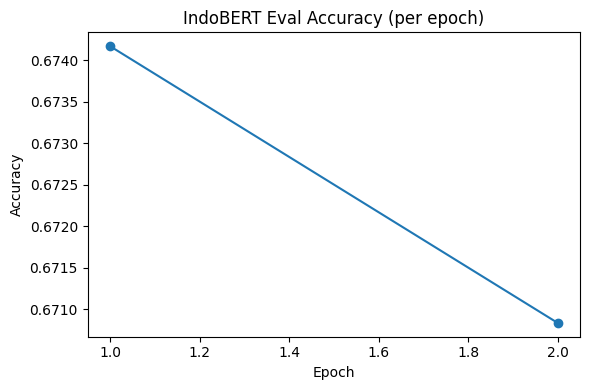

Saved image: acc_indobert.png


In [14]:


!pip install -q evaluate
!pip install -q --upgrade transformers datasets accelerate

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

# -------------------------
# CONFIG
# -------------------------
DATA_PATH = "spotify_uap_6000_balanced.csv"
OUT_DIR = "models/indobert"
MODEL_NAME = "indobenchmark/indobert-base-p1"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs("models", exist_ok=True)

# -------------------------
# LOAD DATA
# -------------------------
df = pd.read_csv(DATA_PATH)
texts = df["text_clean"].astype(str).tolist()
labels = df["label"].astype(str).tolist()

le = LabelEncoder()
y = le.fit_transform(labels)

# Save label classes (buat streamlit & laporan)
with open("models/label_classes.json", "w") as f:
    json.dump(le.classes_.tolist(), f)

X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

train_ds = Dataset.from_dict({"text": X_train, "label": y_train})
test_ds  = Dataset.from_dict({"text": X_test,  "label": y_test})

print("Train size:", len(train_ds), "Test size:", len(test_ds))
print("Classes:", le.classes_)

# -------------------------
# TOKENIZE
# -------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

# -------------------------
# MODEL
# -------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(le.classes_)
)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels_ = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels_)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels_, average="macro")["f1"],
    }

# NOTE:
# Kamu sebelumnya kena TypeError saat pakai evaluation_strategy/logging_strategy.
# Di versi transformers baru, aman pakai eval_strategy & logging_strategy.
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    eval_strategy="epoch",          # <-- versi baru
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# -------------------------
# TRAIN
# -------------------------
trainer.train()

# Save model & tokenizer
trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)

# -------------------------
# PREDICT & REPORT
# -------------------------
pred_out = trainer.predict(test_ds)
y_pred = np.argmax(pred_out.predictions, axis=1)

print("\n=== Classification Report (IndoBERT) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("=== Confusion Matrix (Raw) ===")
print(confusion_matrix(y_test, y_pred))

# -------------------------
# CONFUSION MATRIX HEATMAP (KAYA CONTOH)
# -------------------------
def plot_confusion_matrix_heatmap(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha="right")
    plt.yticks(tick_marks, labels)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("Label Sebenarnya")
    plt.xlabel("Label Prediksi")
    plt.tight_layout()

    # Simpan gambar untuk laporan (opsional tapi bagus)
    plt.savefig("cm_indobert.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_confusion_matrix_heatmap(
    y_test, y_pred,
    labels=le.classes_,
    title="Confusion Matrix IndoBERT"
)

print("Saved image: cm_indobert.png")

# -------------------------
# LOSS PLOT (DARI LOG TRAINER)
# -------------------------
log_history = trainer.state.log_history
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss  = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_acc   = [x["eval_accuracy"] for x in log_history if "eval_accuracy" in x]

if train_loss:
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(train_loss)+1), train_loss, marker="o")
    plt.title("IndoBERT Training Loss (per epoch)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.savefig("loss_indobert.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved image: loss_indobert.png")

if eval_loss:
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(eval_loss)+1), eval_loss, marker="o")
    plt.title("IndoBERT Eval Loss (per epoch)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.savefig("eval_loss_indobert.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved image: eval_loss_indobert.png")

if eval_acc:
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(eval_acc)+1), eval_acc, marker="o")
    plt.title("IndoBERT Eval Accuracy (per epoch)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.savefig("acc_indobert.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved image: acc_indobert.png")


train_pretrained_distilbert.py

Train: 4800 Test: 1200
Classes: ['negatif' 'netral' 'positif']


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2966515947.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.909300,0.825522,0.601667,0.600619
2,0.744300,0.803454,0.614167,0.614671



=== Classification Report (DistilBERT) ===
              precision    recall  f1-score   support

     negatif       0.58      0.65      0.61       400
      netral       0.50      0.47      0.48       400
     positif       0.78      0.72      0.75       400

    accuracy                           0.61      1200
   macro avg       0.62      0.61      0.61      1200
weighted avg       0.62      0.61      0.61      1200

=== Confusion Matrix (Raw) ===
[[260 119  21]
 [151 188  61]
 [ 40  71 289]]


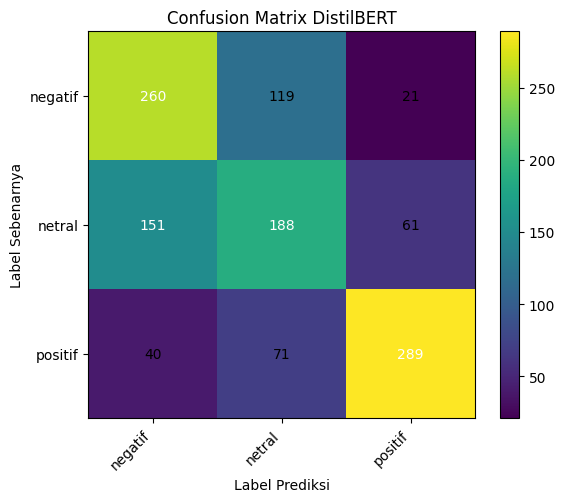

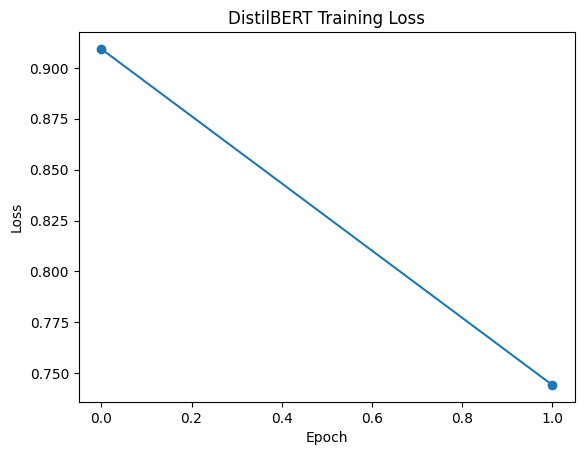

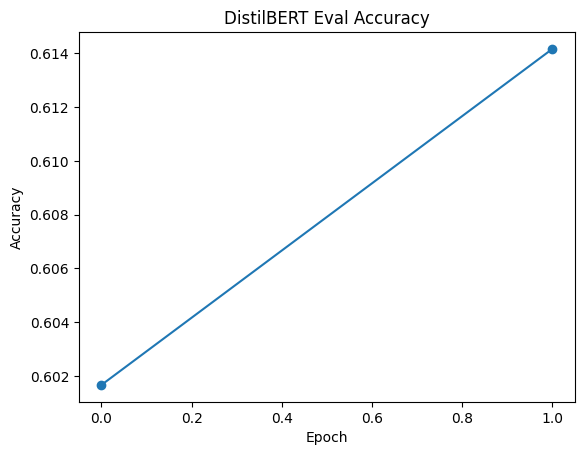

In [16]:

!pip install -q evaluate
!pip install -q --upgrade transformers datasets accelerate

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

# -------------------------
# CONFIG
# -------------------------
DATA_PATH = "spotify_uap_6000_balanced.csv"
OUT_DIR = "models/distilbert"
MODEL_NAME = "distilbert-base-multilingual-cased"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs("models", exist_ok=True)

# -------------------------
# LOAD DATA
# -------------------------
df = pd.read_csv(DATA_PATH)
texts = df["text_clean"].astype(str).tolist()
labels = df["label"].astype(str).tolist()

le = LabelEncoder()
y = le.fit_transform(labels)

with open("models/label_classes.json", "w") as f:
    json.dump(le.classes_.tolist(), f)

X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

train_ds = Dataset.from_dict({"text": X_train, "label": y_train})
test_ds  = Dataset.from_dict({"text": X_test,  "label": y_test})

print("Train:", len(train_ds), "Test:", len(test_ds))
print("Classes:", le.classes_)

# -------------------------
# TOKENIZE
# -------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

# -------------------------
# MODEL
# -------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(le.classes_)
)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels_ = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels_)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels_, average="macro")["f1"],
    }

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    eval_strategy="epoch",      # ✅ FIX DI SINI
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# -------------------------
# TRAIN
# -------------------------
trainer.train()

trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)

# -------------------------
# PREDICTION & REPORT
# -------------------------
pred_out = trainer.predict(test_ds)
y_pred = np.argmax(pred_out.predictions, axis=1)

print("\n=== Classification Report (DistilBERT) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("=== Confusion Matrix (Raw) ===")
print(confusion_matrix(y_test, y_pred))

# -------------------------
# CONFUSION MATRIX HEATMAP
# -------------------------
def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()

    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha="right")
    plt.yticks(ticks, labels)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("Label Sebenarnya")
    plt.xlabel("Label Prediksi")
    plt.tight_layout()
    plt.savefig("cm_distilbert.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_cm(y_test, y_pred, le.classes_, "Confusion Matrix DistilBERT")

# -------------------------
# LOSS & ACC PLOT
# -------------------------
log_hist = trainer.state.log_history
train_loss = [x["loss"] for x in log_hist if "loss" in x]
eval_loss  = [x["eval_loss"] for x in log_hist if "eval_loss" in x]
eval_acc   = [x["eval_accuracy"] for x in log_hist if "eval_accuracy" in x]

if train_loss:
    plt.figure()
    plt.plot(train_loss, marker="o")
    plt.title("DistilBERT Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("loss_distilbert.png", dpi=300, bbox_inches="tight")
    plt.show()

if eval_acc:
    plt.figure()
    plt.plot(eval_acc, marker="o")
    plt.title("DistilBERT Eval Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.savefig("acc_distilbert.png", dpi=300, bbox_inches="tight")
    plt.show()


model_evaluation_comparison.py

In [18]:
import pandas as pd

results = [
    {"Model": "BiLSTM (Base)", "Accuracy": 0.58, "F1_Macro": 0.59},
    {"Model": "IndoBERT", "Accuracy": 0.67, "F1_Macro": 0.67},
    {"Model": "DistilBERT mBERT", "Accuracy": 0.61, "F1_Macro": 0.61},
]

df = pd.DataFrame(results)
print(df)

# Simpan untuk README
df.to_csv("model_comparison.csv", index=False)
print("Saved: model_comparison.csv")


              Model  Accuracy  F1_Macro
0     BiLSTM (Base)      0.58      0.59
1          IndoBERT      0.67      0.67
2  DistilBERT mBERT      0.61      0.61
Saved: model_comparison.csv


In [20]:
import shutil
from google.colab import files

# Nama file zip
zip_name = "models_uap_spotify.zip"

# Zip seluruh folder models
shutil.make_archive("models_uap_spotify", "zip", "models")

# Download
files.download(zip_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>